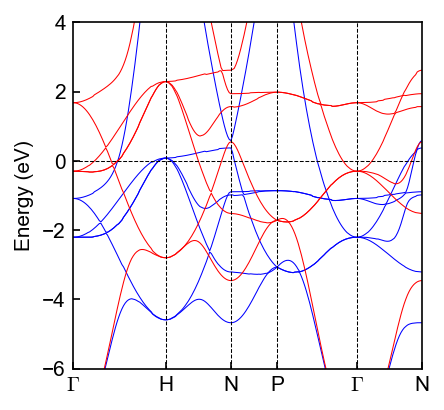

In [1]:
import os
import sys
import subprocess
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
#------------------------------------------------------------------------

### Read band.xy file
def read_band(file_path, x_column, y_column, b_column, l_column):
    x_value = []
    y_value = []
    b_value = []
    l_value = []
    with open(file_path, 'r') as file:
        #next(file) 
        for line in file:
            data = line.strip().split()
            if len(data) != 0 and data[0] != '#':
                if len(data) >= max(x_column, y_column, b_column, l_column):
                    x_value.append(float(data[x_column - 1]))
                    y_value.append(float(data[y_column - 1]))
                    b_value.append(int(data[b_column - 1]))
                    l_value.append(int(data[l_column - 1]))
    return x_value, y_value, b_value, l_value
    
def get_band(file_path, x_column, y_column, b_column, l_column, y_const):
    x_value, y_value, b_value, l_value = read_band(file_path, x_column, y_column, b_column, l_column)
    y_value=[ y - y_const for y in y_value ]
    istr=[]
    iend=[]
    b_band=[]
    iiband=0
    ii=0
    for i in range(len(b_value)):
        if b_value[i] != iiband:
            ii=ii+1
            iiband=b_value[i]
            b_band.append(iiband)
            istr.append(i)
            iend.append(i)
        else:
            iend[ii-1]=i
    x_band=[]
    y_band=[]
    for i in range(len(istr)):
        iistr=istr[i]
        iiend=iend[i]+1
        x_band.append(x_value[iistr:iiend])
        y_band.append(y_value[iistr:iiend])
    l_band=[]
    l_band.append(x_value[0])
    llband=l_value[0]
    for l in range(len(l_value)):
        if b_value[l] == b_value[0]:
            if l_value[l] != llband:
                llband=l_value[l]
                l_band.append(x_value[l-1])
    l_band.append(x_value[l])
    return x_band, y_band, b_band, l_band
#------------------------------------------------------------------------

### MAIN PROGRAM
if __name__ == '__main__':
    
    ### SETTING #########################################################
    # get fermi energy
    scf_file="../lapwoutSCF"
    result = subprocess.run(["grep","fermi",scf_file], capture_output=True, text=True)
    lines = result.stdout.strip().split()
    fermi = float(lines[-1])*27.2116   #in eV

    # set (x,y) axes
    fig = plt.figure(dpi=150,figsize=(3,3))
    xlabel_plot="k-direction"
    ylabel_plot="Energy (eV)"

    # set K symmetry (x-axis)
    k_plot = [r"$\Gamma$","H","N","P",r"$\Gamma$","N"]

    # set min and max in energy and dos
    ymin_plot=-6.0; ymax_plot= 4.001; ystp_plot = 2.0
    
    # set column in dos.xy
    xcol_data=[]; ycol_data=[]; bcol_data=[]; lcol_data=[]; color_data=[]; style_data=[]
    file_data = './band.xy'
    #up-spin
    xcol_data.append(4)                      #k
    ycol_data.append(5)                      #eng
    bcol_data.append(7)                      #band index
    lcol_data.append(8)                      #line index    
    color_data.append('blue')                #'black' ...
    style_data.append('-')                   #solid line="-"
    #down-spin
    xcol_data.append(4)                      #dos
    ycol_data.append(6)                      #eng
    bcol_data.append(7)                      #band index
    lcol_data.append(8)                      #line index    
    color_data.append('red')                 #'black' ...
    style_data.append('-')                   #solid line="-"
    
    ### READ DATA #########################################################
    # read dos.xy
    x_plot=[]; y_plot=[]; b_plot=[] 
    for i in range(len(xcol_data)):
        x_data, y_data, b_data, l_data = get_band(file_data, xcol_data[i], ycol_data[i], bcol_data[i], lcol_data[i], fermi)
        x_plot.append(x_data)
        y_plot.append(y_data)
        b_plot.append(b_data)
        if i == 0 : l_plot=l_data
    #print('kmin=',np.min(x_plot),'  kmax=',np.max(x_plot))
    #print('engmin=',np.min(y_plot),'  engmax=',np.max(y_plot))
    #print('k-bound=',l_plot)

    # set min and max in axis
    xmin_plot = np.amin(x_plot); xmax_plot = np.amax(x_plot)

    ### FIGURE #########################################################\    
    # plot band
    for i in range(len(x_plot)):
        x_data=x_plot[i]
        y_data=y_plot[i]
        for j in range(len(b_plot[i])):
            x=x_data[j][0:]
            y=y_data[j][0:]
            plt.plot(x, y, color=color_data[i], linestyle=style_data[i], linewidth=0.5)

    # set axis limit
    plt.xlim(xmin_plot, xmax_plot)
    plt.ylim(ymin_plot, ymax_plot)

    # set x-axis
    for i in range(len(l_plot)-2) :
        plt.axvline(l_plot[i+1], color='black', linestyle='--', linewidth=0.5)
    plt.xticks(l_plot,k_plot,fontsize=10)
    #plt.xlabel(xlabel_plot, fontsize=10)
    
    # set y-axis
    plt.yticks([])
    plt.yticks(np.arange(ymin_plot, ymax_plot, ystp_plot),fontsize=10)
    plt.ylabel(ylabel_plot, fontsize=10)
    
    # set zero
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5) 
   
    # save/draw figure
    plt.savefig('fig_band.png',format='png',bbox_inches='tight',transparent=True)
    plt.show()
    plt.clf()
    plt.close()